function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect,600000)

# Install & import

In [1]:
# importing libraries
from scipy import special as sp 
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Encode/Decode & other functions

In [2]:
upper_limit = 8     # upper limit of r_dB
iteration = 500     # number of error bits to collect

##################### useful functions #####################

# 두 개의 행렬을 곱하고 mod 2 를 취한다.
def mul(a,b):
    return np.where(np.matmul(a,b)%2==0,0,1)

# k개의 0이 있고 나머지는 1인 가능한 모든 codeword를 생성한다.
# n=4,k=2의 경우 6개의 가능한 codeword가 생성되며, 
# 그 결과 다음과 같이 (6,4) 행렬이 생성된다.
# array([[1., 0., 1., 0.],
#        [1., 1., 0., 0.],
#        [1., 0., 0., 1.],
#        [0., 1., 1., 0.],
#        [0., 1., 0., 1.],
#        [0., 0., 1., 1.]])
def combination(n,k):
    a = np.append(np.zeros(k),np.ones(n-k))
    return np.array(list(set(itertools.permutations(a))))

# generator matrix에서 I와 함께 이어 붙일 P 행렬을 만든다. 
# combination함수를 이용해서 만드는데, [7,4] 코드의 경우 다음과 같다.
# array([[1., 1., 1.],
#        [0., 1., 1.],
#        [1., 1., 0.],
#        [1., 0., 1.]])
def make_P(n,k):
    r = int(np.log2(n))+1
    P = combination(n-k,0)
    for i in range(1,r-1):
        P = np.concatenate((P,combination(n-k,i)),axis=0)
    return P

##################### encode & decode ##############################

# generator matrix와 information bit를 곱한다.
def encode(info,G):
    x = mul(info,G)  
    return x

# standard array decoding 인데, candidates는 standard array의
# 모든 원소가 들어있다. 이와 비교해서 가장 가까운 codeword를 반환한다.
def decode_std(code,candidates):
    return candidates[np.argmin(np.sum(candidates != code, axis = 1))]

# syndrome decoding을 위한 함수이다. parity check matrix H를 이용해
# 신드롬을 계산하고, 해당 신드롬이 H에 있다면 해당 index의 bit가 
# 오류인 것이다. 이때 만약 없다면 2개의 H원소로 신드롬을 나타낼 수 있다면
# 그 두개의 원소에 해당하는 인덱스 두개가 오류가 있는 bit이다.
# 이때 2개의 원소로 현재 계산한 신드롬을 나타내는 가짓수가 여러가지라면
# 랜덤하게 하나를 정한다.
def decode(code,H):
    ht = H.T.astype(int)
    syndrome = mul(H,code).astype(int)  # 신드롬 계산
    L = len(ht) 
    if np.sum(syndrome) == 0:           # 신드롬이 0이라면 오류가 없는 것
        return code
    else:                               # 오류가 한가지라면 H에 신드롬과 같은 원소가 있을 것
        idx = np.argwhere( np.sum( ht ^ syndrome , axis=1 ) == 0 )
        if len(idx) == 0:               # idx가 비어있다는 것은 오류가 한가지가 아니란 것
            for i in range(L):          # 두개의 H원소의 합이 신드롬을 나타낼 수 있는 경우를 찾는다
                for j in range(L):    
                    if np.array_equal(ht[i] ^ ht[j],  syndrome) :
                        idx = [i,j]     # 두개를 반환. 여러 쌍이라면 마지막 쌍이 자동으로 저장 됨
        code[idx] = np.where(code[idx]==1,0,1)

        return code
################################ ideal ##############################

# Q function을 계산하기 위한 함수이다
def qfunc(x):                           .
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

# Uncoded인 경우의 이론상의 값을 출력한다. 교재의 식을 참고하였다.
def ideal():                            
    y_uncoded = []
    y_coded = []
    x = np.arange(0,upper_limit+2)
    for gamma in x:         # 감마값에 따른 MER을 계산한다.
        d = 10**(gamma/10)
        p = qfunc(np.sqrt(2*d))     
        y_uncoded.append(p)
    name = 'Ideal uncoded'
    return [x,y_uncoded,y_uncoded,name]  
################################ initialize ####################### 

# Hamming code를 위한 G,H 행렬을 생성한다.
# reduced Hamming code의 경우 우선 perfect의 경우의 G행렬에서 열과행을 삭제하여 만든다.
def hamming_init(n,k):
    r = int(np.log2(n))+1   # redundant bit의 개수를 계산한다.
    N = 2**r-1              
    P = make_P(n,k)         # P행렬을 만들어 I와 이어 붙여 G를 만든다.
    P_shortened = P[N-n:,:] # reduced의 경우 행을 삭제한다. perfect의 경우 N-n이 0이므로 삭제되지 않는다.
    
    #G와 H를 위한 identity matrices
    I_g = np.eye(k)         
    I_h = np.eye(n-k) 

    # G와 H를 만든다.
    G = np.concatenate((I_g,P_shortened),axis=1)
    H = np.concatenate((P_shortened.T,I_h),axis=1)

    return G, H 

# golay code를 위한 G 행렬과 standard array를 생성한다.    
def golay_init():
    # 생성 가능한 모든 12개 길이의 코드를 생성하여 저장한다.
    info = list(itertools.product([0, 1], repeat=12))
    np.array(info)

    A = np.array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
                  [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1],
                  [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1],
                  [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0],
                  [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
                  [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1],
                  [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
                  [1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
                  [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
                  [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0],
                  [1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]])
    A = A[:,:-1]
    I = np.eye(12)
    G = np.concatenate((I,A),axis=1)      #generator matrix 

    # 가능한 모든 information bits와 G를 곱하여 가능한 모든 codeword를 생성한다.
    candidates = np.matmul(info,G)                   #possible codewords
    candidates = np.where(candidates%2==0,0,1)       #mod 2
    return G, candidates

# repetition code를 위한 G 행렬과 standard array를 생성한다.
def rep_init(num_of_info,rep):
    # 가능한 모든 information bit를 생성한다,
    info = np.array(list(itertools.product([0, 1], repeat=num_of_info)))

    I = np.eye(num_of_info)
    G = np.tile(I,rep)                               #Generator matrix
    
    # 가능한 모든 information bits와 G를 곱하여 가능한 모든 codeword를 생성한다.
    candidates = np.matmul(info,G)                   #possible codewords
    candidates = np.where(candidates%2==0,0,1)       #mod 2
    return G, candidates

# Channel function

In [3]:
# simulation을 위한 함수이다. 위에서 정의한 모든 함수를 활용한다.
# [n,k] code word를 위해 n,k를 입력, code_type은 세개의 인코딩 타입중 하나를 선택한다.
# 감마 값이 0부터 8까지 늘어나며 error bit의 개수가 500개가 넘을 때까지 bit error rate을 기록한다.
# 하지만 감마가 8이 넘어도 BER이 10^-3보다 크다면 그보다 작아질 때까지 진행한다.
def channel(n,k,code_type):
    rep = int(n/k)      # 몇번 반복하는지를 나타낸 변수이다. Hamming이나 Golay에서는 사용하지 않는다.
    R = k/n
    #initialize 
    ber = 1             # ber 변수를 초기화. while문에 진입하기 위해서 1보다 큰 값으로 초기화 해야한다.
    r_dB = 0
    BER = []
    FER = []
    r_list = []         # 감마값이며, 그래프 상의 x축을 위해 저장한다.

    # code type에 맞는 initial 함수를 통해 G, H 혹은 standard array를 생성한다.
    if code_type == 'g':
        name = 'Golay ['+str(n)+','+str(k)+']'
        G,candidates = golay_init()
    elif code_type == 'h':
        name = 'Hamming ['+str(n)+','+str(k)+']'
        G,H = hamming_init(n,k)
    elif code_type == 'r':
        G ,candidates= rep_init(k,rep)
        if rep == 1:
            name = 'Uncoded simulated'
        else:
            name = 'Repetition of '+str(rep)+' times'
    else:
        print('Wrong type!')
        return 1

    # info bit를 인코딩한다. 이번 시뮬레이션의 information bit는 
    # 모두 0이라 인코딩이 의미가 없지만 보다 범용적인 프로그램으로 만들었다.
    x_encoded = encode(np.zeros(k),G)
    x_encoded_BPSK = 1-2*x_encoded  # BPSK coding

    # 감마가 8보다 크고, BER이 10^-3보다 작을 때 멈춘다.
    while(ber >= 0.001 or r_dB <= upper_limit):
        print(r_dB,end=' ')     #시뮬레이션 구동중 현재 감마값을 출력하여 현황을 알 수 있게 한다.
        num_word = 0
        num_bit = 0
        err_word = 0
        err_bit = 0

        # noise를 만들기 위한 표준편차이다
        std_dev = np.sqrt((10**(-(r_dB)/10))/(2*R))

        # err_bit가 500개 보다 많을 때 까지 loop를 돈다.
        # 인코딩된 정보비트에 AWGN을 더하고
        # BPSK의 역연산을 하고 디코딩을 하여 전송한 비트와 비교하여 BER을 계산한다.
        while(err_bit <= 500):
            noise = np.random.normal(0,std_dev,n)           # noise follows Gaussian
            y_encoded = x_encoded_BPSK+noise                # message received
            y_encoded =  np.where(y_encoded < 0, 1, 0)      # decode by threshold

            # hamming의 경우만 syndrome decoding을 하므로 경우를 나눈다.
            if code_type == 'h':
                y_decoded = decode(y_encoded,H)
            else:
                y_decoded = decode_std(y_encoded,candidates)

            err = np.where(y_decoded != x_encoded)[0]       # counting errors

            # err의 개수가 0이 아닌경우 word error와 bit error의 개수를 더한다
            if len(err) != 0:
                err_word += 1
                err_bit += len(err)

            # BER의 분모가 될 값들이다. 
            # 매번 새로운 word와 bits를 보내므로 자동으로 증가시킨다.
            num_word += 1
            num_bit += n
            ber = err_bit/num_bit

        # 매 감마 마다 BER과 FER을 리스트에 추가한다.
        BER.append(ber)                 
        FER.append(err_word/num_word)   
        r_list.append(r_dB)
        r_dB += 1
        
    print("")
    #리스트로 묶어서 이후 Plot 함수에서 용이하게 쓸수 있는 형태로 반환한다.  
    return [r_list,BER,FER,name]                              

# Plot function

In [15]:
# 그래프를 한번에 그려주는 함수로, 편의를 위해 만들었다.
# 첫번째 argument인 graph_list는 channel 함수가 반환한 값들을 원소로 가지는 리스트이다.
# type은 BER과 FER을 구별하기 위해 input으로 넣어준다.
# 본 함수는 시뮬레이션 및 본 프로젝트의 목적성과 관련이 없기 때문에 자세한 설명을 생략한다.
def plot_graph(graph_list,type):
    fig = plt.figure(figsize=(25,15))
    ax = fig.add_subplot(1, 1, 1)
    if type=='f':
        t_name = 'FER'
        t = 2
    else:
        t_name = 'BER'
        t = 1

    ax.set_title(t_name,fontsize=30)
    ax.set_xlabel('E_b/N_0 (dB)',fontsize=15)
    ax.set_ylabel(t_name,fontsize=15)

    for i in graph_list:
        ax.scatter(i[0],i[t])
        ax.plot(i[0],i[t],label=i[3])

    minor_ticks = np.arange(0, 9, 0.1)
    ax.set_xticks(minor_ticks, minor=True)
    plt.yscale('log')
    plt.legend(fontsize=15)

    plt.grid(which='minor',alpha = 0.2)
    plt.grid()

    plt.show()

# 실행

0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 
0 1 2 3 4 5 6 7 8 
0 1 2 3 4 5 6 7 8 
0 1 2 3 4 5 6 7 8 


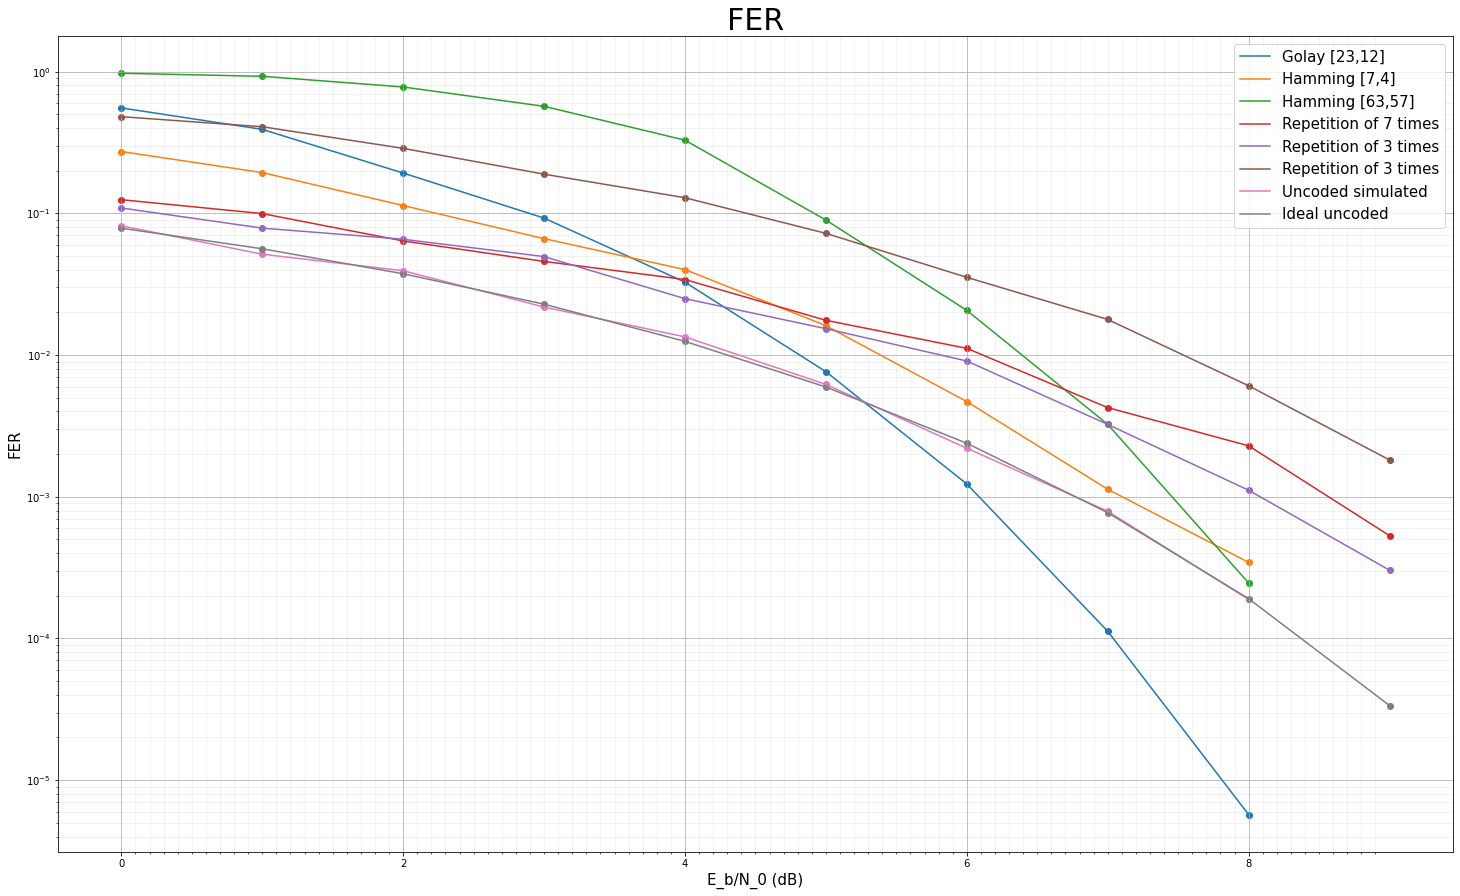

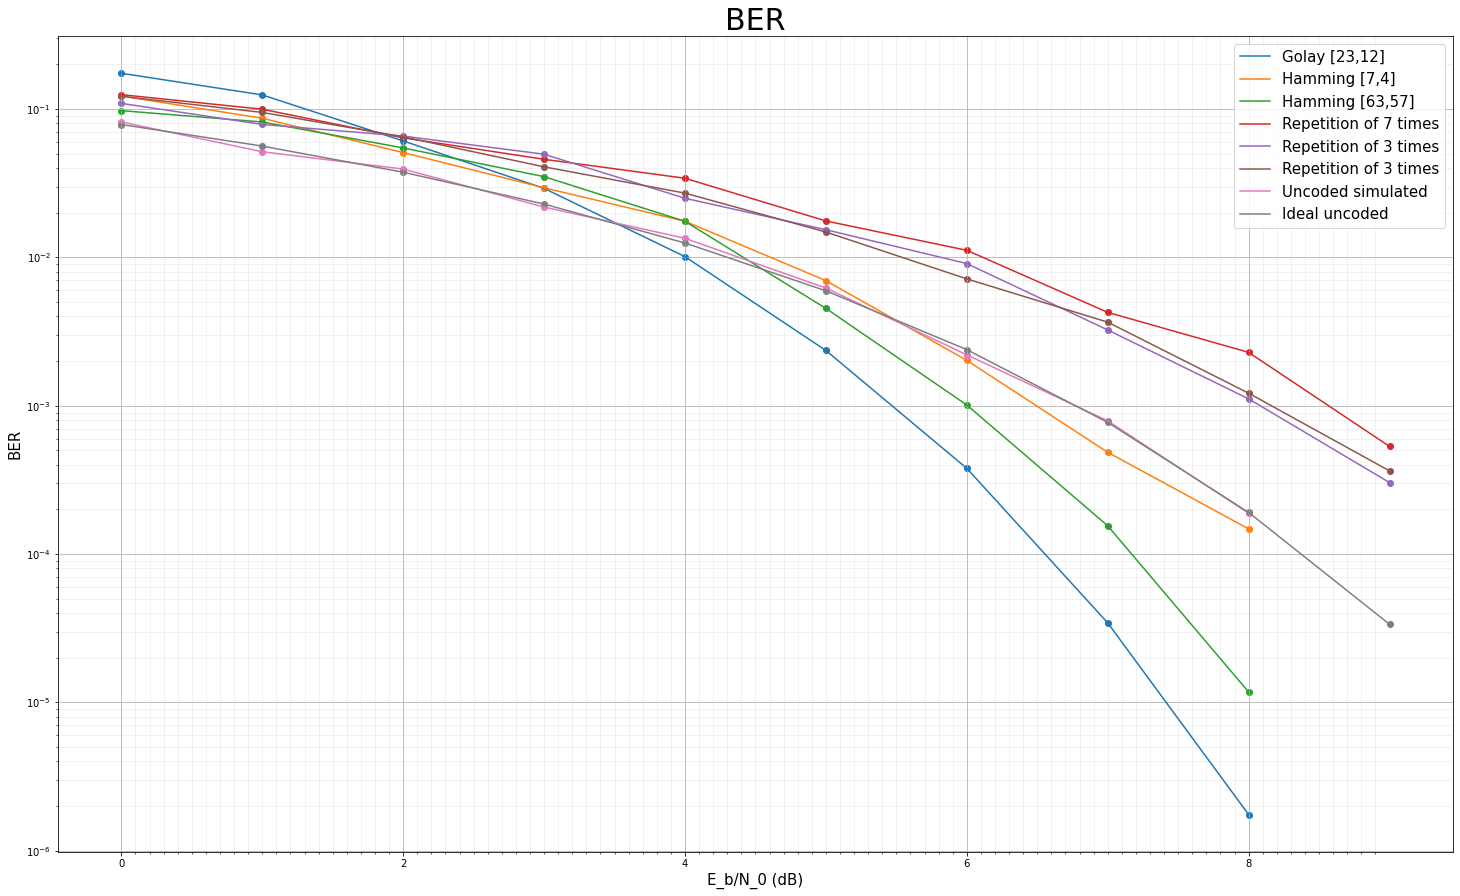

In [5]:
r7 = channel(7,1,'r')       # 7 time repetition

# r3와 r3_5는 3번 반복하는 함수로 서로 같지만, 후자의 경우 codeword의 길이가 5이다. 
# 따라서 두 함수의 BER은 같지만 FER은 다르다.
# 이를 그래프를 통해 확인할 수 있다.
r3 = channel(3,1,'r')       # 3 time repetition  with 1 code word
r3_5 = channel(15,5,'r')    # 3 time repetition with 5 code word

# Uncoded의 경우 위에서 다룬 ideal 함수로 대체하지만,
# 1개의 information을 1번 반복한, 즉 uncoded된 경우의 시뮬레이션 결과와 
# 비슷하게 나오는지 확인하기 위해 실행하였다.
u = channel(1,1,'r')        # uncoded simulated
i = ideal()                 # uncoded ideal

# Hamming code의 두 가지 경우와 Golay 코드이다.
h7 = channel(7,4,'h')       # 7,4 hamming
h63 = channel(63,57,'h')    # 63,57 hamming
g_23 = channel(23,12,'g')   # Golay code

# FER과 BER을 그려보자
plot_graph([g_23,h7,h63,r7,r3,r3_5,u,i],'f')     #ploting graphs for FER
plot_graph([g_23,h7,h63,r7,r3,r3_5,u,i],'b')     #ploting graphs for BER

0 1 2 3 4 5 6 7 
0 1 2 3 4 5 6 7 
0 1 2 3 4 5 6 7 
0 1 2 3 4 5 6 7 
0 1 2 3 4 5 6 7 
0 1 2 3 4 5 6 7 
0 1 2 3 4 5 6 7 
0 1 2 3 4 5 6 7 


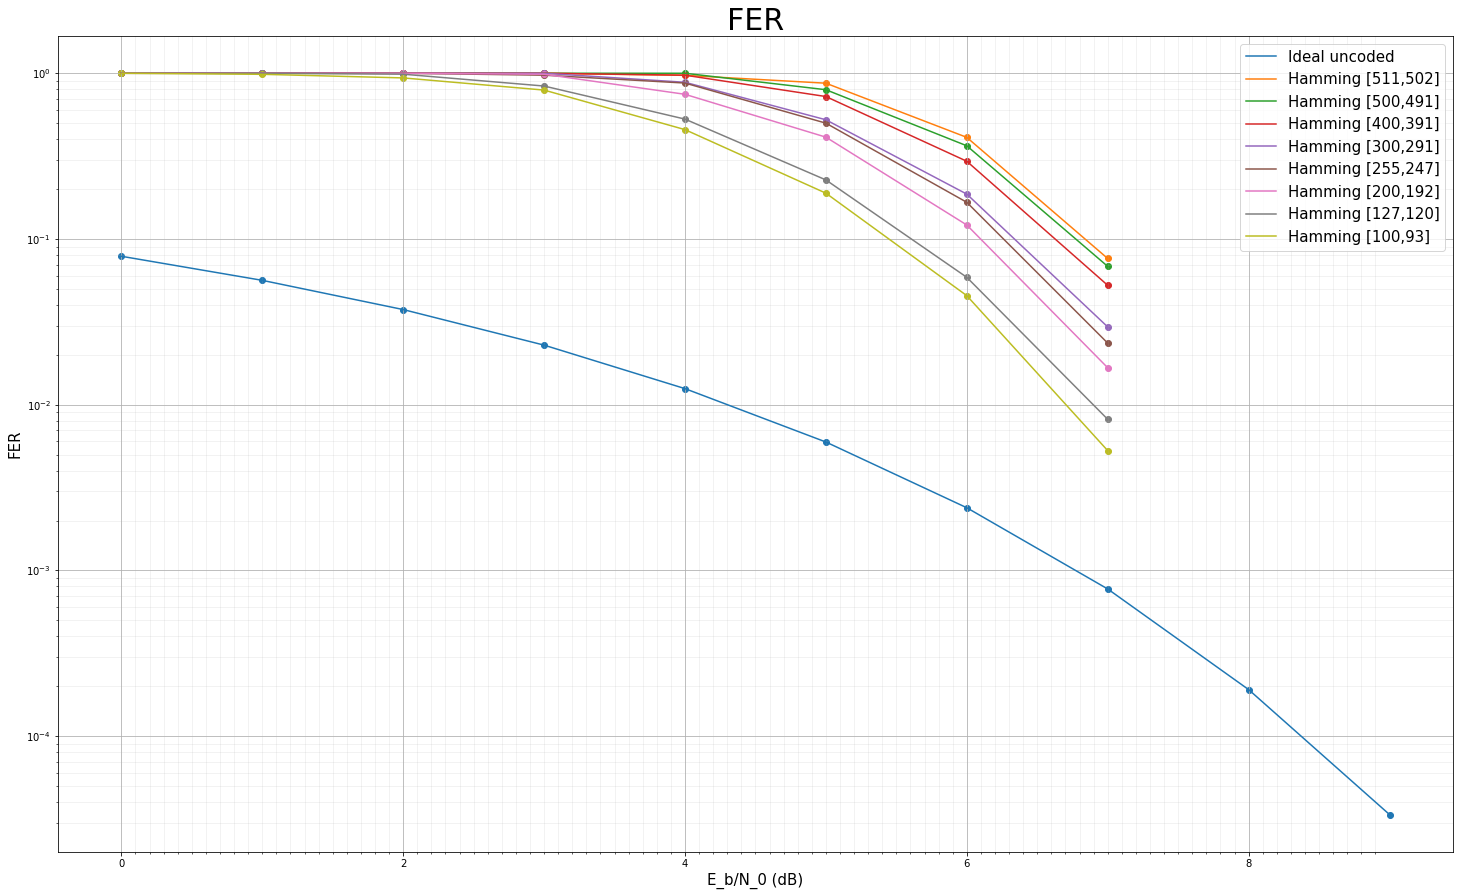

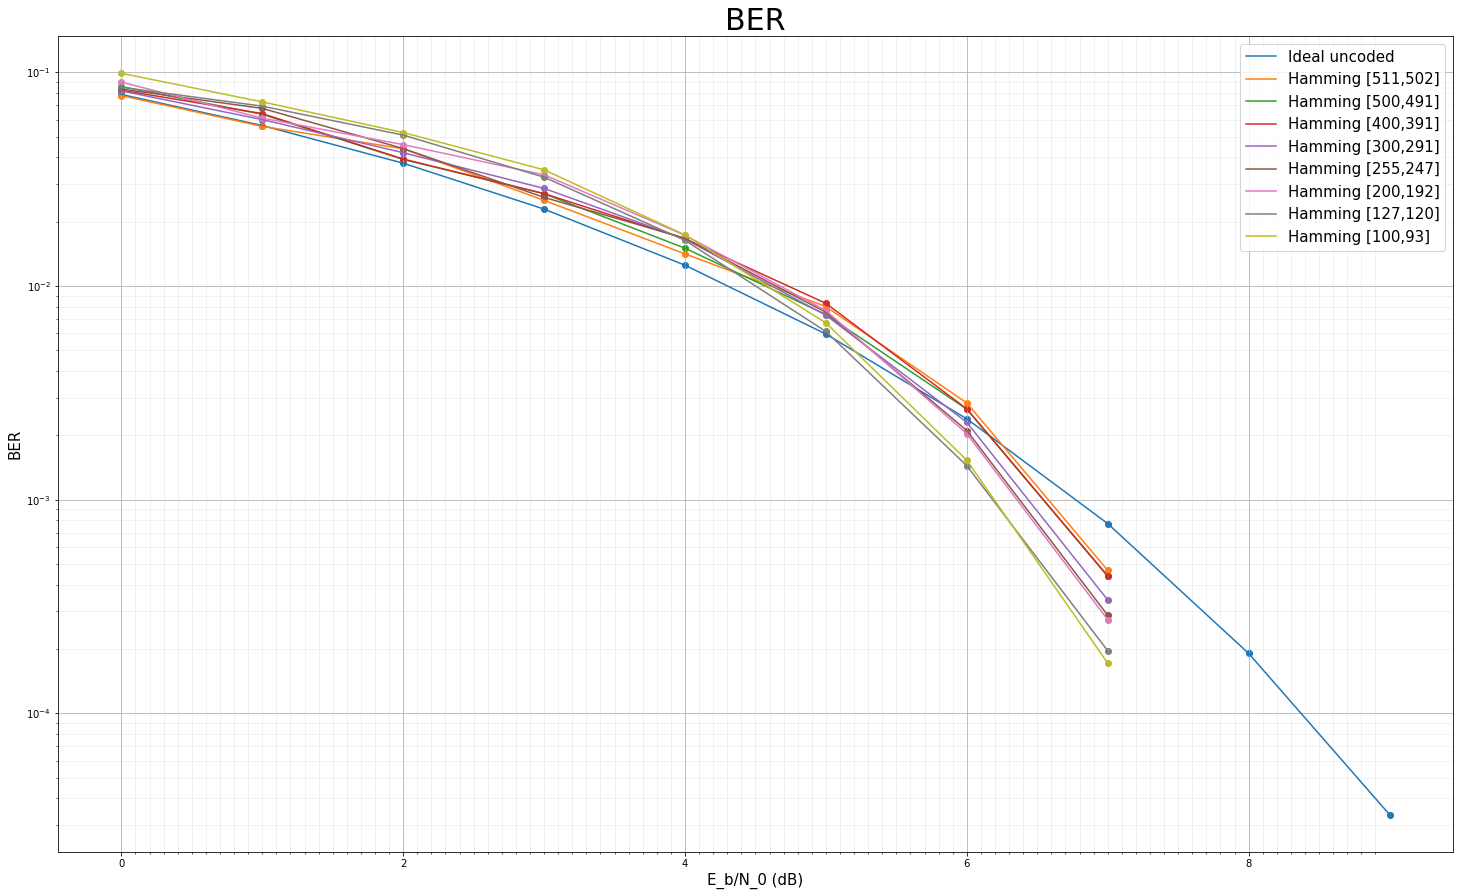

In [16]:
upper_limit = 1 # channel 함수의 while을 보면 r_dB 값이 upper_limit 보다 크고 
                # 동시에 10^-3 보다 ber이 작아져야 반복문을 탈출한다.
                # 따라서 upper_limit을 1로 설정하므로써 while의 조건 중
                # r_dB 값이 upper_limit 보다 큰 조건이 바로 만족되고,
                # 따라서 ber이 10^-3보다 작아지는 것만 만족하면 된다.

h511 = channel(511,502,'h') # [511,502] code
h255 = channel(255,247,'h') # [255,247] code
h127 = channel(127,120,'h') # [127,120] code

h500 = channel(500,491,'h') # [500,491] code
h400 = channel(400,391,'h') # [400,391] code
h300 = channel(300,291,'h') # [300,291] code
h200 = channel(200,192,'h') # [200,192] code
h100 = channel(100,93,'h')  # [100,93] code

plot_graph([i,h511,h500,h400,h300,h255,h200,h127,h100],'f')  # plot FER graphs
plot_graph([i,h511,h500,h400,h300,h255,h200,h127,h100],'b')  # plot BER graphs